##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import keras

In [4]:
# Use Keras 2.
version_fn = getattr(keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

Import `matplotlib` and create a helper function to plot graphs:

In [5]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [6]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [7]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [9]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"A shaky hand-held camera was used, presumably to give the film a documentary look, but the effect was so exaggerated that I started to get motion-sickness just from watching it. It looked like someone with cerebral palsy was holding the camera (no offense meant to CP sufferers, but I don't think you would expect to get much work as a cinematographer!) The camera work was so nauseating, and so distracting, that my wife and I considered it unwatchable and gave up on it after 10 minutes of torture. I checked back a while later (it was showing on TV), and it hadn't gotten any better. I suggest giving this one a miss unless you need to get rid of any bad sushi you may have eaten!"
 b"I absolutely LOVE this movie and would really like to have it someday. It's just a fascinating legend about an eagle who wears a Turquoise necklace, I loved it and would like to see it again! I don't remember too much about it, but that a Native American boy lives in a nice village with his family, a

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [11]:
VOCAB_SIZE = 1000
encoder = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [13]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  4,   1,   1, ...,   0,   0,   0],
       [ 10, 412, 116, ...,   0,   0,   0],
       [541,   1,   7, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [14]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"A shaky hand-held camera was used, presumably to give the film a documentary look, but the effect was so exaggerated that I started to get motion-sickness just from watching it. It looked like someone with cerebral palsy was holding the camera (no offense meant to CP sufferers, but I don't think you would expect to get much work as a cinematographer!) The camera work was so nauseating, and so distracting, that my wife and I considered it unwatchable and gave up on it after 10 minutes of torture. I checked back a while later (it was showing on TV), and it hadn't gotten any better. I suggest giving this one a miss unless you need to get rid of any bad sushi you may have eaten!"
Round-trip:  a [UNK] [UNK] camera was used [UNK] to give the film a documentary look but the effect was so [UNK] that i started to get [UNK] just from watching it it looked like someone with [UNK] [UNK] was [UNK] the camera no [UNK] meant to [UNK] [UNK] but i dont think you would expect to get much wo

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [15]:
model = keras.Sequential([
    encoder,
    keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [16]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [17]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Convert to numpy array and cast to object dtype
input_array = np.array([sample_text]).astype(object)

#predictions = model.predict(np.array([sample_text]))
predictions = model.predict(input_array)
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[0.00965887]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [18]:
# predict on a sample text with padding

padding = "the " * 2000

# Convert to numpy array and cast to object dtype
input_array = np.array([sample_text,padding]).astype(object)

#predictions = model.predict(np.array([sample_text, padding]))
predictions = model.predict(input_array)
print(predictions[0])

1/1 [==============================] - 0s 89ms/step
[0.00965887]


Compile the Keras model to configure the training process:

In [19]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#Calculating carbon emissions during model training

In [ ]:
!pip install codecarbon
from codecarbon import EmissionsTracker

## Train the model

In [21]:
#start emissions tracking
tracker = EmissionsTracker()
tracker.start()

#Model training
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

#stop emissions tracking
emissions: float = tracker.stop()
print(f"Emissions during training: {emissions} kg CO2")

[codecarbon WARNING @ 23:38:28] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 23:38:28] [setup] RAM Tracking...
[codecarbon INFO @ 23:38:28] [setup] CPU Tracking...
[codecarbon WARNING @ 23:38:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 23:38:29] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 23:38:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 23:38:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 23:38:29] [setup] GPU Tracking...
[codecarbon INFO @ 23:38:29] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:38:29] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/10


[codecarbon INFO @ 23:38:44] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:38:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:38:44] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 23:38:44] Energy consumed for all GPUs : 0.000112 kWh. Total GPU Power : 26.825150576198677 W
[codecarbon INFO @ 23:38:44] 0.000331 kWh of electricity used since the beginning.


 63/391 [===>..........................] - ETA: 45s - loss: 0.6927 - accuracy: 0.4921

[codecarbon INFO @ 23:38:59] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:38:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:38:59] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 23:38:59] Energy consumed for all GPUs : 0.000238 kWh. Total GPU Power : 30.220989942147696 W
[codecarbon INFO @ 23:38:59] 0.000676 kWh of electricity used since the beginning.


253/391 [==================>...........] - ETA: 12s - loss: 0.6724 - accuracy: 0.5249

[codecarbon INFO @ 23:39:14] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:39:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:39:14] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 23:39:14] Energy consumed for all GPUs : 0.000407 kWh. Total GPU Power : 40.680539393307164 W
[codecarbon INFO @ 23:39:14] 0.001064 kWh of electricity used since the beginning.


391/391 [==============================] - 58s 94ms/step - loss: 0.6092 - accuracy: 0.6024 - val_loss: 0.4336 - val_accuracy: 0.7927
Epoch 2/10
 25/391 [>.............................] - ETA: 21s - loss: 0.4176 - accuracy: 0.8056

[codecarbon INFO @ 23:39:29] Energy consumed for RAM : 0.000167 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:39:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:39:29] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 23:39:29] Energy consumed for all GPUs : 0.000571 kWh. Total GPU Power : 39.374887568350644 W
[codecarbon INFO @ 23:39:29] 0.001446 kWh of electricity used since the beginning.


276/391 [====================>.........] - ETA: 6s - loss: 0.3895 - accuracy: 0.8230

[codecarbon INFO @ 23:39:44] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:39:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:39:44] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 23:39:44] Energy consumed for all GPUs : 0.000755 kWh. Total GPU Power : 43.99555235421592 W
[codecarbon INFO @ 23:39:44] 0.001848 kWh of electricity used since the beginning.


391/391 [==============================] - 26s 67ms/step - loss: 0.3750 - accuracy: 0.8301 - val_loss: 0.3514 - val_accuracy: 0.8458
Epoch 3/10
 93/391 [======>.......................] - ETA: 16s - loss: 0.3240 - accuracy: 0.8585

[codecarbon INFO @ 23:39:59] Energy consumed for RAM : 0.000250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:39:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:39:59] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 23:39:59] Energy consumed for all GPUs : 0.000937 kWh. Total GPU Power : 43.63895918163588 W
[codecarbon INFO @ 23:39:59] 0.002249 kWh of electricity used since the beginning.


353/391 [==========================>...] - ETA: 2s - loss: 0.3350 - accuracy: 0.8537

[codecarbon INFO @ 23:40:14] Energy consumed for RAM : 0.000292 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:40:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:40:14] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 23:40:14] Energy consumed for all GPUs : 0.001124 kWh. Total GPU Power : 44.95728586399376 W
[codecarbon INFO @ 23:40:14] 0.002655 kWh of electricity used since the beginning.


391/391 [==============================] - 24s 61ms/step - loss: 0.3329 - accuracy: 0.8544 - val_loss: 0.3462 - val_accuracy: 0.8453
Epoch 4/10
176/391 [============>.................] - ETA: 13s - loss: 0.3241 - accuracy: 0.8604

[codecarbon INFO @ 23:40:29] Energy consumed for RAM : 0.000333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:40:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:40:29] Energy consumed for All CPU : 0.001417 kWh
[codecarbon INFO @ 23:40:29] Energy consumed for all GPUs : 0.001310 kWh. Total GPU Power : 44.75067640676464 W
[codecarbon INFO @ 23:40:29] 0.003060 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:40:29] 0.003536 g.CO2eq/s mean an estimation of 111.51834494898064 kg.CO2eq/year


391/391 [==============================] - 25s 64ms/step - loss: 0.3191 - accuracy: 0.8620 - val_loss: 0.3289 - val_accuracy: 0.8505


[codecarbon INFO @ 23:40:44] Energy consumed for RAM : 0.000375 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:40:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:40:44] Energy consumed for All CPU : 0.001594 kWh
[codecarbon INFO @ 23:40:44] Energy consumed for all GPUs : 0.001499 kWh. Total GPU Power : 45.37537514302838 W
[codecarbon INFO @ 23:40:44] 0.003468 kWh of electricity used since the beginning.


Epoch 5/10
  1/391 [..............................] - ETA: 1:41 - loss: 0.2682 - accuracy: 0.8906

[codecarbon INFO @ 23:40:59] Energy consumed for RAM : 0.000417 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:40:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:40:59] Energy consumed for All CPU : 0.001771 kWh
[codecarbon INFO @ 23:40:59] Energy consumed for all GPUs : 0.001620 kWh. Total GPU Power : 28.986533858877845 W
[codecarbon INFO @ 23:40:59] 0.003807 kWh of electricity used since the beginning.


239/391 [=================>............] - ETA: 9s - loss: 0.3113 - accuracy: 0.8637

[codecarbon INFO @ 23:41:14] Energy consumed for RAM : 0.000458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:41:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:41:14] Energy consumed for All CPU : 0.001948 kWh
[codecarbon INFO @ 23:41:14] Energy consumed for all GPUs : 0.001811 kWh. Total GPU Power : 45.766277207986185 W
[codecarbon INFO @ 23:41:14] 0.004216 kWh of electricity used since the beginning.


391/391 [==============================] - 26s 65ms/step - loss: 0.3117 - accuracy: 0.8637 - val_loss: 0.3288 - val_accuracy: 0.8531


[codecarbon INFO @ 23:41:29] Energy consumed for RAM : 0.000500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:41:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:41:29] Energy consumed for All CPU : 0.002125 kWh
[codecarbon INFO @ 23:41:29] Energy consumed for all GPUs : 0.001983 kWh. Total GPU Power : 41.432309831795834 W
[codecarbon INFO @ 23:41:29] 0.004608 kWh of electricity used since the beginning.


Epoch 6/10
 76/391 [====>.........................] - ETA: 17s - loss: 0.3119 - accuracy: 0.8647

[codecarbon INFO @ 23:41:44] Energy consumed for RAM : 0.000541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:41:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:41:44] Energy consumed for All CPU : 0.002302 kWh
[codecarbon INFO @ 23:41:44] Energy consumed for all GPUs : 0.002124 kWh. Total GPU Power : 33.83880492432608 W
[codecarbon INFO @ 23:41:44] 0.004967 kWh of electricity used since the beginning.


336/391 [========================>.....] - ETA: 3s - loss: 0.3092 - accuracy: 0.8685

[codecarbon INFO @ 23:41:59] Energy consumed for RAM : 0.000583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:41:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:41:59] Energy consumed for All CPU : 0.002479 kWh
[codecarbon INFO @ 23:41:59] Energy consumed for all GPUs : 0.002319 kWh. Total GPU Power : 46.83040624905636 W
[codecarbon INFO @ 23:41:59] 0.005381 kWh of electricity used since the beginning.


391/391 [==============================] - 24s 60ms/step - loss: 0.3085 - accuracy: 0.8679 - val_loss: 0.3243 - val_accuracy: 0.8500


[codecarbon INFO @ 23:42:14] Energy consumed for RAM : 0.000625 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:42:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:42:14] Energy consumed for All CPU : 0.002656 kWh
[codecarbon INFO @ 23:42:14] Energy consumed for all GPUs : 0.002464 kWh. Total GPU Power : 34.76045226836636 W
[codecarbon INFO @ 23:42:14] 0.005745 kWh of electricity used since the beginning.


Epoch 7/10
133/391 [=========>....................] - ETA: 16s - loss: 0.3068 - accuracy: 0.8695

[codecarbon INFO @ 23:42:29] Energy consumed for RAM : 0.000666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:42:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:42:29] Energy consumed for All CPU : 0.002833 kWh
[codecarbon INFO @ 23:42:29] Energy consumed for all GPUs : 0.002625 kWh. Total GPU Power : 38.65456308137782 W
[codecarbon INFO @ 23:42:29] 0.006124 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:42:29] 0.003542 g.CO2eq/s mean an estimation of 111.71395050021432 kg.CO2eq/year


387/391 [============================>.] - ETA: 0s - loss: 0.3041 - accuracy: 0.8694

[codecarbon INFO @ 23:42:44] Energy consumed for RAM : 0.000708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:42:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:42:44] Energy consumed for All CPU : 0.003010 kWh
[codecarbon INFO @ 23:42:44] Energy consumed for all GPUs : 0.002825 kWh. Total GPU Power : 47.941852532100555 W
[codecarbon INFO @ 23:42:44] 0.006543 kWh of electricity used since the beginning.


391/391 [==============================] - 25s 62ms/step - loss: 0.3045 - accuracy: 0.8691 - val_loss: 0.3233 - val_accuracy: 0.8589


[codecarbon INFO @ 23:42:59] Energy consumed for RAM : 0.000750 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:42:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:42:59] Energy consumed for All CPU : 0.003187 kWh
[codecarbon INFO @ 23:42:59] Energy consumed for all GPUs : 0.002960 kWh. Total GPU Power : 32.51138012099271 W
[codecarbon INFO @ 23:42:59] 0.006897 kWh of electricity used since the beginning.


Epoch 8/10
204/391 [==============>...............] - ETA: 11s - loss: 0.3028 - accuracy: 0.8688

[codecarbon INFO @ 23:43:14] Energy consumed for RAM : 0.000791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:43:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:43:14] Energy consumed for All CPU : 0.003364 kWh
[codecarbon INFO @ 23:43:14] Energy consumed for all GPUs : 0.003145 kWh. Total GPU Power : 44.28606125673939 W
[codecarbon INFO @ 23:43:14] 0.007300 kWh of electricity used since the beginning.


391/391 [==============================] - 25s 64ms/step - loss: 0.3062 - accuracy: 0.8681 - val_loss: 0.3233 - val_accuracy: 0.8542
Epoch 9/10
 29/391 [=>............................] - ETA: 23s - loss: 0.3027 - accuracy: 0.8718

[codecarbon INFO @ 23:43:29] Energy consumed for RAM : 0.000833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:43:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:43:29] Energy consumed for All CPU : 0.003541 kWh
[codecarbon INFO @ 23:43:29] Energy consumed for all GPUs : 0.003346 kWh. Total GPU Power : 48.23558543788009 W
[codecarbon INFO @ 23:43:29] 0.007719 kWh of electricity used since the beginning.


286/391 [====================>.........] - ETA: 6s - loss: 0.3012 - accuracy: 0.8699

[codecarbon INFO @ 23:43:44] Energy consumed for RAM : 0.000875 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:43:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:43:44] Energy consumed for All CPU : 0.003718 kWh


288/391 [=====================>........] - ETA: 6s - loss: 0.3004 - accuracy: 0.8702

[codecarbon INFO @ 23:43:44] Energy consumed for all GPUs : 0.003552 kWh. Total GPU Power : 49.40681741176728 W
[codecarbon INFO @ 23:43:44] 0.008144 kWh of electricity used since the beginning.


391/391 [==============================] - 24s 60ms/step - loss: 0.3034 - accuracy: 0.8676 - val_loss: 0.3277 - val_accuracy: 0.8609


[codecarbon INFO @ 23:43:59] Energy consumed for RAM : 0.000916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:43:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:43:59] Energy consumed for All CPU : 0.003895 kWh
[codecarbon INFO @ 23:43:59] Energy consumed for all GPUs : 0.003719 kWh. Total GPU Power : 40.12450819028774 W
[codecarbon INFO @ 23:43:59] 0.008530 kWh of electricity used since the beginning.


Epoch 10/10
100/391 [======>.......................] - ETA: 17s - loss: 0.3019 - accuracy: 0.8695

[codecarbon INFO @ 23:44:14] Energy consumed for RAM : 0.000958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:44:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:44:14] Energy consumed for All CPU : 0.004072 kWh
[codecarbon INFO @ 23:44:14] Energy consumed for all GPUs : 0.003874 kWh. Total GPU Power : 37.338669536066334 W
[codecarbon INFO @ 23:44:14] 0.008904 kWh of electricity used since the beginning.


347/391 [=========================>....] - ETA: 2s - loss: 0.2983 - accuracy: 0.8721

[codecarbon INFO @ 23:44:29] Energy consumed for RAM : 0.001000 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:44:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:44:29] Energy consumed for All CPU : 0.004249 kWh
[codecarbon INFO @ 23:44:29] Energy consumed for all GPUs : 0.004081 kWh. Total GPU Power : 49.6114023180249 W
[codecarbon INFO @ 23:44:29] 0.009329 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:44:29] 0.003705 g.CO2eq/s mean an estimation of 116.84254303952017 kg.CO2eq/year


391/391 [==============================] - 25s 63ms/step - loss: 0.2998 - accuracy: 0.8707 - val_loss: 0.3276 - val_accuracy: 0.8630


[codecarbon INFO @ 23:44:33] Energy consumed for RAM : 0.001009 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:44:33] Delta energy consumed for CPU with constant : 0.000042 kWh, power : 42.5 W
[codecarbon INFO @ 23:44:33] Energy consumed for All CPU : 0.004291 kWh
[codecarbon INFO @ 23:44:33] Energy consumed for all GPUs : 0.004131 kWh. Total GPU Power : 50.39428018456091 W
[codecarbon INFO @ 23:44:33] 0.009431 kWh of electricity used since the beginning.


Emissions during training: 0.0013085513047349044 kg CO2


In [22]:
emissions_data = tracker.final_emissions_data
print(f"Energy consumed: {emissions_data.energy_consumed:.6f} kWh")
print(f"Execution Time: {emissions_data.duration:.2f} seconds")
print(f"Emissions: {emissions_data.emissions} kg CO2")

Energy consumed: 0.009431 kWh
Execution Time: 363.67 seconds
Emissions: 0.0013085513047349044 kg CO2


In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 23s 58ms/step - loss: 0.3231 - accuracy: 0.8625
Test Loss: 0.32307273149490356
Test Accuracy: 0.8625199794769287


(0.0, 0.6246429964900017)

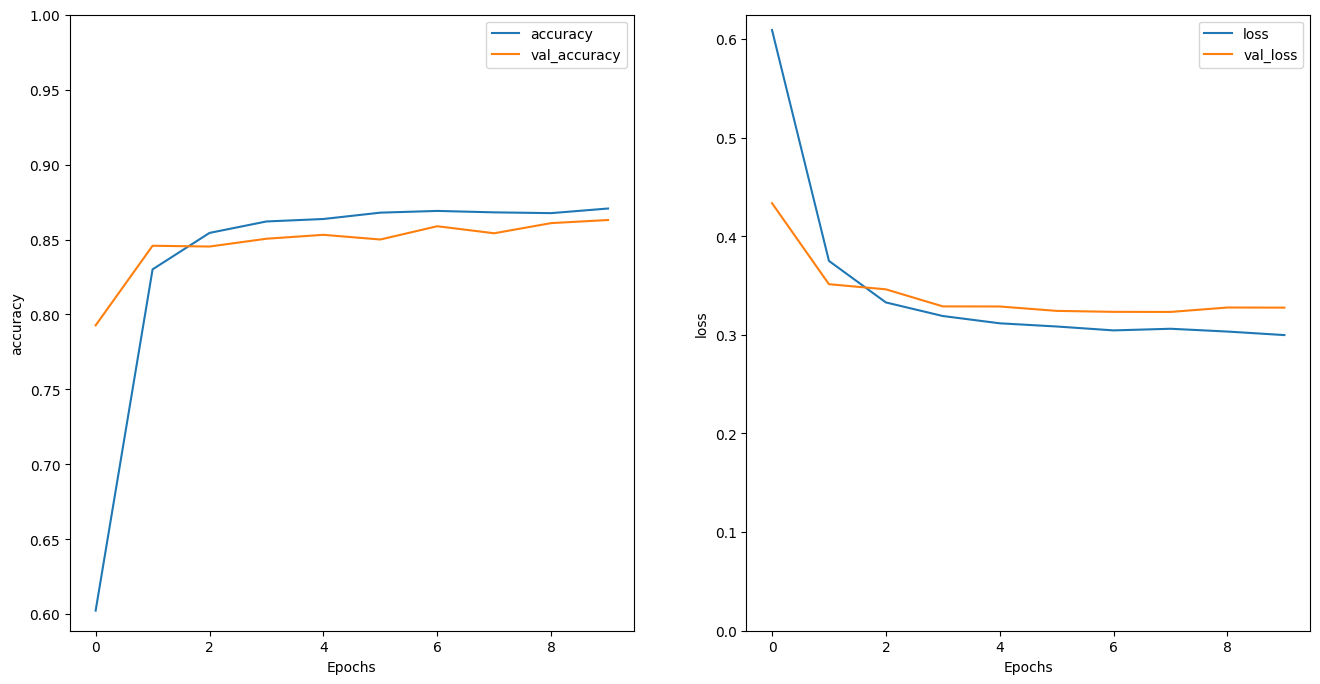

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [25]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Convert to numpy array and cast to object dtype
input_array = np.array([sample_text]).astype(object)

#predictions = model.predict(np.array([sample_text]))
predictions = model.predict(input_array)
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.6569855]
